In [1]:
import h5py
import numpy as np
from numpy.random import default_rng
from sklearn.metrics import accuracy_score

from smml.kernels import GaussianKernel, PolynomialKernel
from smml.models import MulticlassPegasos, Pegasos
from smml.cross_validation import KFoldCrossValidation, ParamGridCrossValidation

d:\Users\gabri\anaconda3\envs\p3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = '../../datasets/usps/usps.h5'
with h5py.File(PATH, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [ ]:
N = 1000
N_test = 300
X_train = X_tr[:N]
y_train = y_tr[:N]
X_test = X_te[:N_test]
y_test = y_te[:N_test]

In [ ]:
p = Pegasos(T=16000, kernel=PolynomialKernel())

In [ ]:
p.fit(X_tr, np.where(y_tr == 8, 1, -1))

In [ ]:
mp = MulticlassPegasos(T=32000, kernel=PolynomialKernel(n=5))

In [ ]:
mp.fit(X_tr, y_tr)

In [ ]:
mp.score(X_te, y_te)

In [ ]:
KFoldCV = KFoldCrossValidation(5)

In [ ]:
KFoldCV.cross_validate(mp, X_train, y_train)

In [6]:
mp = MulticlassPegasos(kernel=PolynomialKernel(n=5))
cv = KFoldCrossValidation(5)
param_grid = {'T': np.linspace(500, 30000, 7, dtype=int), 'l': np.logspace(-7, 2, 7)}

In [7]:
pgcv = ParamGridCrossValidation(mp, param_grid, cv)

In [8]:
res = pgcv.fit(X_tr, y_tr)
res

Looping on parameters grid: 100%|██████████| 49/49 [13:16<00:00, 16.26s/it]


{(('T', 500), ('l', 1e-07)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.5375},
 (('T', 500), ('l', 3.162277660168379e-06)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.559375},
 (('T', 500), ('l', 0.0001)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.759375},
 (('T', 500), ('l', 0.0031622776601683794)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.7875},
 (('T', 500), ('l', 0.1)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.80625},
 (('T', 500), ('l', 3.1622776601683795)): {'error': 0.14701609238295246,
  'accuracy': 0.8529839076170476,
  'time': 0.790625},
 (('T', 500), ('l', 100.0)): {'error': 0.14715364396479563,
  'accuracy': 0.8528463560352044,
  'time': 0.775},
 (('T', 5416), ('l', 1e-07)): {'error': 0.047735745694273676,
  'accuracy': 0.9522642543057265,
  'time': 1.2875},
 (('T', 5416), ('l', 3.162277660168379e-06))

In [51]:
np.save('res.npy', res)

In [9]:
values = list(param_grid.values())
values

[array([  500,  5416, 10333, 15250, 20166, 25083, 30000]),
 array([1.00000000e-07, 3.16227766e-06, 1.00000000e-04, 3.16227766e-03,
        1.00000000e-01, 3.16227766e+00, 1.00000000e+02])]

In [11]:
errors = np.array([val['error'] for val in res.values()]).reshape((7,7)).round(3)
errors

array([[0.147, 0.147, 0.147, 0.147, 0.147, 0.147, 0.147],
       [0.048, 0.048, 0.048, 0.048, 0.048, 0.047, 0.047],
       [0.039, 0.039, 0.039, 0.039, 0.039, 0.039, 0.04 ],
       [0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.032],
       [0.034, 0.034, 0.034, 0.034, 0.034, 0.033, 0.029],
       [0.034, 0.034, 0.034, 0.034, 0.034, 0.035, 0.028],
       [0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.029]])

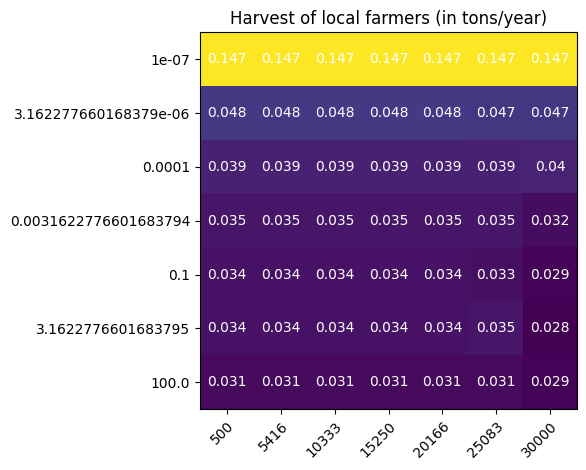

In [23]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, ax = plt.subplots()
im = ax.imshow(errors)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(values[0])), labels=values[0])
ax.set_yticks(np.arange(len(values[1])), labels=values[1])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(values[1])):
    for j in range(len(values[0])):
        text = ax.text(i, j, errors[j, i],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [69]:
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['cmr10']

In [58]:
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist]

['DejaVu Serif',
 'DejaVu Sans Display',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'STIXGeneral',
 'cmmi10',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'cmr10',
 'STIXNonUnicode',
 'cmss10',
 'STIXSizeOneSym',
 'DejaVu Sans',
 'STIXNonUnicode',
 'STIXSizeFourSym',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Serif Display',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'cmsy10',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'cmtt10',
 'STIXSizeFiveSym',
 'STIXSizeTwoSym',
 'STIXGeneral',
 'cmb10',
 'STIXNonUnicode',
 'cmex10',
 'Baskerville Old Face',
 'Bookman Old Style',
 'Freestyle Script',
 'Gill Sans Nova',
 'Tempus Sans ITC',
 'Malgun Gothic',
 'Rockwell Nova',
 'Myanmar Text',
 'Corbel',
 'Elephant',
 'Trebuchet MS',
 'Ink Free',
 'Georgia Pro',
 'HP Simplified',
 'Elephant',
 'Gill Sans Nova',
 'Rockwell Nova',
 'Vivaldi',
 'Century Schoolbook',
 'Book An

In [59]:
[f.name for f in matplotlib.font_manager.fontManager.afmlist]

['Times',
 'ZapfDingbats',
 'ITC Bookman',
 'New Century Schoolbook',
 'Courier',
 'Courier',
 'Helvetica',
 'Helvetica',
 'Courier',
 'Helvetica',
 'Helvetica',
 'Times',
 'ITC Avant Garde Gothic',
 'Computer Modern',
 'Times',
 'Symbol',
 'Palatino',
 'ITC Avant Garde Gothic',
 'Times',
 'Utopia',
 'Computer Modern',
 'Courier',
 'Symbol',
 'Helvetica',
 'Utopia',
 'Helvetica',
 'Palatino',
 'Palatino',
 'Helvetica',
 'Times',
 'Courier',
 'Helvetica',
 'ITC Zapf Dingbats',
 'Computer Modern',
 'Computer Modern',
 'Utopia',
 'ITC Bookman',
 'Computer Modern',
 'New Century Schoolbook',
 'Courier',
 'Utopia',
 'Times',
 'Helvetica',
 'New Century Schoolbook',
 'Helvetica',
 'Helvetica',
 'Times',
 'Palatino',
 'ITC Avant Garde Gothic',
 'ITC Avant Garde Gothic',
 'Courier',
 'New Century Schoolbook',
 'ITC Bookman',
 'ITC Bookman',
 'Helvetica',
 'ITC Zapf Chancery',
 'Helvetica',
 'Helvetica',
 'Courier',
 'Times']

In [90]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, norm=colors.LogNorm(vmin=data.min(), vmax=data.max()), **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, extend='max', **cbar_kw)
    cbar.ax.invert_yaxis()
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", top=False, left=False, bottom=False)

    ax.set_xlabel(r'Regularization coefficient ($\lambda$)')
    ax.set_ylabel('Number of rounds (T)')
    ax.set_title('Polynomial Kernel (degree 5)')

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

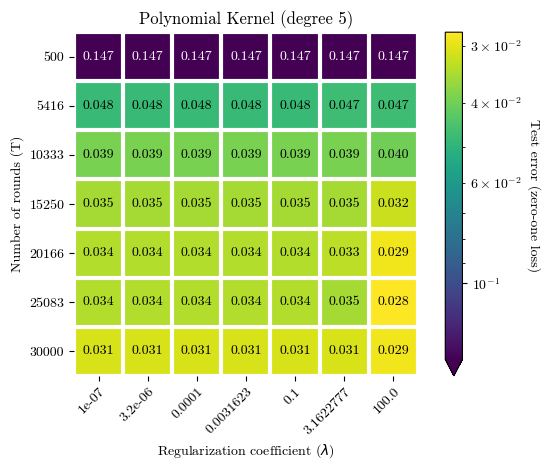

In [91]:
fig, ax = plt.subplots()

im, cbar = heatmap(errors, values[0], np.round(values[1], 7), ax=ax,
                   cmap='viridis_r', cbarlabel="Test error (zero-one loss)")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.savefig('heatmap.svg', dpi=300)